## Now that we have data in our jupyter notebook environment, how do we use it to train a model?

We're going to continue using the sample `pets` data that should now have been unzipped and accessible in `/workspace/data/pets/`.

To get started with training, we're going to need to use a `DataBlock` to set up a `DataLoader`. To access these tools, we will be using the FastAPI library from Fast.AI. Documentation for this library can be found at [https://docs.fast.ai/](https://docs.fast.ai/).

For our purposes, we will be working within the subset of the API for **Computer Vision**.
 - This means we do not need to import all of fast ai (`import fastai`).
 - Instead, we will just need to import the subset of the api for `vision` (`from fastai.vision.all import *`)
   - note that the `*` here means everything within `fastai.vision.all`

In [1]:
from fastai.vision.all import *

Now that we have access to the tools we will need for training, it can be helpful to set a variable for the `path` to where the data is stored. I often put mine in a directory called *TRAINING_DATA*, but yours should be the same as the name extracted from the zip file you will have unzipped.

Using the sample TrainingData data, we should have data in a folder called `TrainingData` inside of `/workspace/data/`. Modify the assignment of `path` in the code cell below to be:  
`path = /workspace/data/TrainingData`  
The `.zip` is dropped here because we are looking at the folder that was created through the unzipping process, and not the compressed file.

In [2]:
path = '/workspace/data/TrainingData'

## What if we're not sure the data is good? In this case, we're not sure it's all image data.

Now that the location of the data is set in a variable, we *might* want to verify that all of our data is image data. If you have collected and organized all of the data, and are confident you don't have any random files in the directories, you may not need this. But, it can be helpful to run it once to ensure we won't have filetype issues going forward.

The code cell below is a **Helper**. You do not always need to run cells like this, they are nice to keep in files like this in case they are needed. Read the comments at the top of the code cell and decide if you should run it or not. Sometimes errors will be outputted because the code wasn't needed and is inappropriate to run, which may have been experienced running helper code during the data science activity.

In [3]:
#HELPER
# only run this test if you've added new data to the training data
# it does NOT need to be run if you're confident that the image files are valid 
failed = verify_images(get_image_files(path)) # this looks at all of the files in our defined path and verifies that they are images, and failures will be placed in the failed variable
failed.map(Path.unlink) # if there are any failes that were not images, remove them from the data
len(failed) # show the number of failed files, ideally this will be 0, but even if it's more than 0 know that those files are now gone and we don't need to worry about them

0

## How do we use a `DataBlock` to create a `DataLoader`?

To train a model, we'll need a `DataLoader`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

The `DataBlock` is a *class* that has a method called `dataloaders()`. The code below first sets up the `DataBlock` and provides values for parameters that support how we will train our data. Once the `DataBlock` is setup, we then call the method `.dataloaders()` on the `DataBlock` class we've established and assigned that `DataLoader` to the variable `dls`.

Here's what we know about our data and what we want to do:
1. We are training a model that will be given an image and provide a label (category).  
    `blocks=(ImageBlock, CategoryBlock)`
1. We are going to use image files as the data to train on.  
    `get_items=get_image_files`
1. We need to split up some of that data into a training set and a validation set.  
    `splitter=RandomSplitter(valid_pct=0.2, seed=42)`
1. The labels, or category names, will come from the names of the folders for our data.  
    `get_y=parent_label`

The parameters and values above are things that we will probably always want to do for this type of training.

However, the values for the parameters of `item_tfms` and `batch_tfms` are things that we should play around with. These let us augment the data during training, they don't modify the actual files, and are called **augmentation transforms**.

Once the `DataBlock` class instance is created using our chosen parameters, the `.dataloaders()` method is then called on the `DataBlock`.  
    `.dataloaders(path, bs=256)`  
This bit of code takes that `DataBlock` class instance, and uses it to look at the data in the `path` variable that we assigned to `/workspace/data/pets` earlier. It also sets a `batch size` of 256, which may, or may not, be the right value to maximize the the resources of your graphics card. This will be discussed more below.

The code cell below shows how you might set everything up in one cell, but we are going to take it a bit slower. If your path is setup correctly, it will run, but know that we're going to take this step by step.

In [4]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')],
    batch_tfms=[
        *aug_transforms(size=192, min_scale=0.75, p_lighting=0.8, do_flip=true),  # Adjust the p_lighting parameter
        Normalize.from_stats(*imagenet_stats)
    ]
).dataloaders(path, bs=30)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest"). Meaning we can send it a picture and it will give us some text.

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be the names of each plant).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

    batch_tfms=[
        *aug_transforms(size=192, min_scale=0.75, p_lighting=0.8, do_flip=true),
        Normalize.from_stats(*imagenet_stats)
    ]

For each batch, which is 256 at a time for this code, set the probability of changing the lighting (p_lighting) of the image to 75% and use random flipping (do_flip=true) for each set of data

Read more about data augmentations, whether at the item level, or batch level, at [https://docs.fast.ai/vision.augment.html](https://docs.fast.ai/vision.augment.html) (you will want to scroll to the bottom to see a list of these parameters)

The code above let's us take a look at how a batch (256 in the code above, `bs=256`) of the data is augmented based on the parameters of the dataloader. 
You should see images that have been:
 - squished into 192 x 192 pixel sized squares (`size=192`)
 - some cropping (`min-scale=0.75`)
 - a change in the brightness or contrast (`p_lighting=0.8`)
 - some random flipping (`do_flip=true`)

These augmentations allow our data to become more than just what the image originally was. Our model doesn't need to require that the original image was taken upside-down sometimes, but can account for that possibility through the data augmentation.

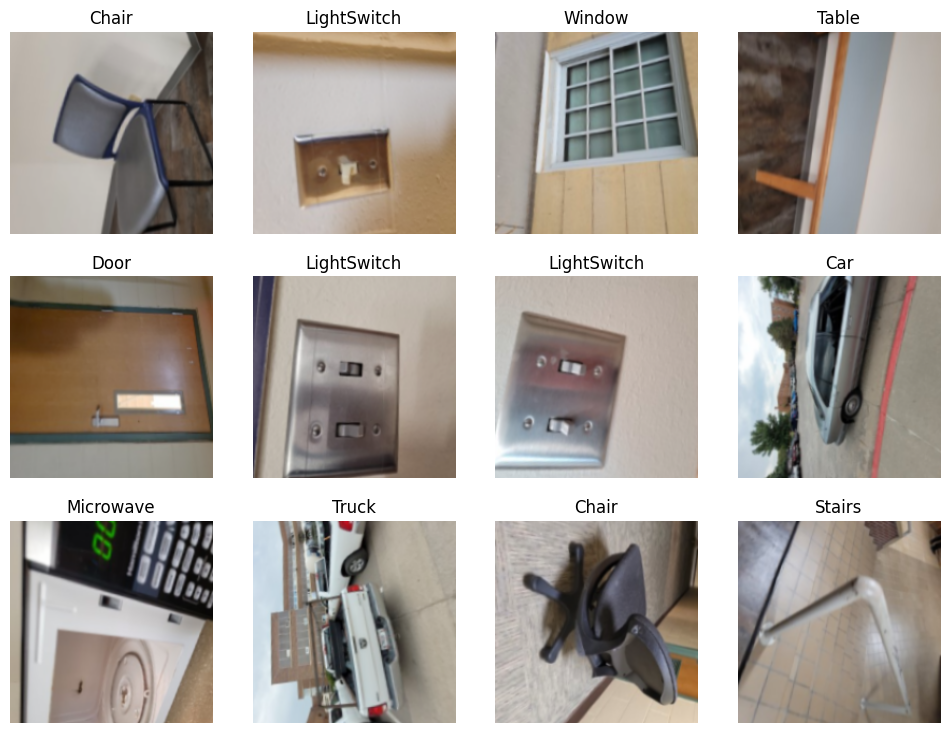

In [5]:
dls.show_batch(max_n=12, nrows=3, ncols=4)

## Let's take things slower and just setup a `DataBlock` first

The code cell below just sets the parameters for our datablock that will likely be consistent. We can then play around with some data augmentations to see what those do.

The code below only establishes a simple augmentation on the items in our dataset that resizes everything to 192x192 pixels.

In [9]:
TrainingData = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(192)
)

Now let's make a dataloader.

In [10]:
dls = TrainingData.dataloaders(path)

And then take a look the data in the dataloader assigned to the variable `dls`.

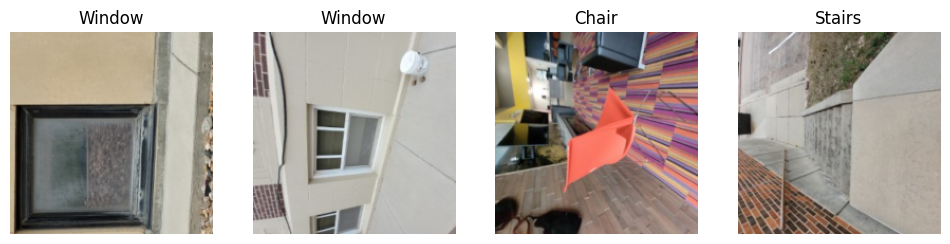

In [11]:
dls.show_batch(max_n=4, nrows=1)

The data looks pretty plain, but all we did was resize it, so that makes sense.

Let's try squishing that data, since not all of our images are square.

The code below creates a new instance of the `DataBlock` assigned to the `pets` variable and overwrites the previous `DataBlock` in `pets`, this time with the images squished into the square form.

**What do you see or notice?**

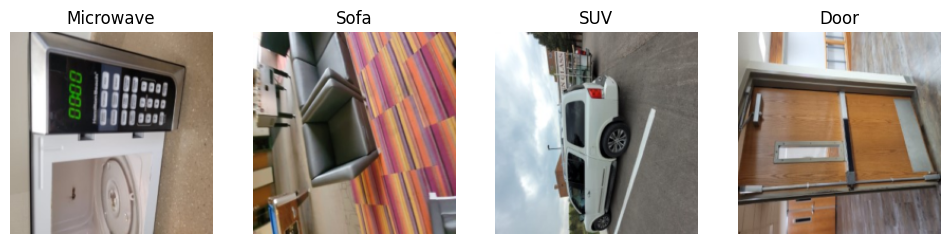

In [12]:
TrainingData = TrainingData.new(item_tfms=Resize(192, 'squish'))
dls = TrainingData.dataloaders(path)
dls.show_batch(max_n=4, nrows=1)

Other resize methods are to pad the sides that don't fit into the square shape. And we can fill that space with black (`pad_mode='zeros'`), stretch out the border (`pad_mode='border'`), or reflect to fill the space (`pad_mode='reflection'`).

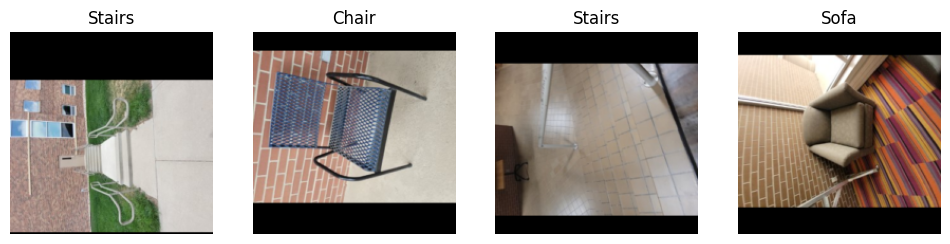

In [13]:
TrainingData = TrainingData.new(item_tfms=Resize(192, 'pad', pad_mode='zeros'))
dls = TrainingData.dataloaders(path)
dls.show_batch(max_n=4, nrows=1)

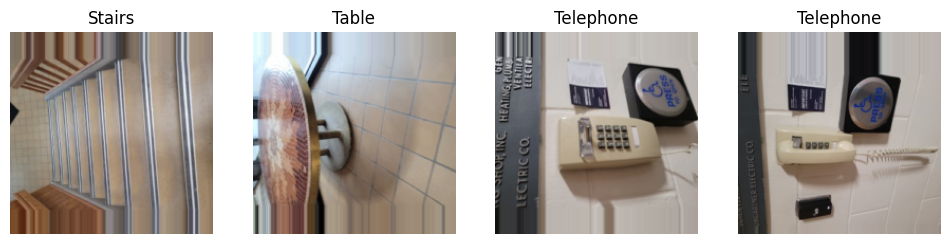

In [15]:
TrainingData = TrainingData.new(item_tfms=Resize(192, 'pad', pad_mode='border'))
dls = TrainingData.dataloaders(path)
dls.show_batch(max_n=4, nrows=1)

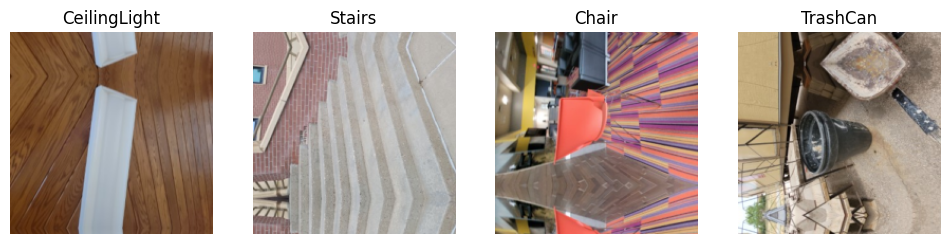

In [16]:
TrainingData = TrainingData.new(item_tfms=Resize(192, 'pad', pad_mode='reflection'))
dls = TrainingData.dataloaders(path)
dls.show_batch(max_n=4, nrows=1)

### **What might the advantages, or disadvantages, be of using each of these methods?**

## What if we want to mix up resizing and cropping?

In stead of locking ourselves into one augmentation method for resizing, we can use the `RandomResizedCrop` function to randomly focus on different parts of the image. The important thing to set is the `min_scale` parameter, which sets the amount of the image to select *at a minimum*.

**Play around with the code below and be prepared to discuss what you notice.**

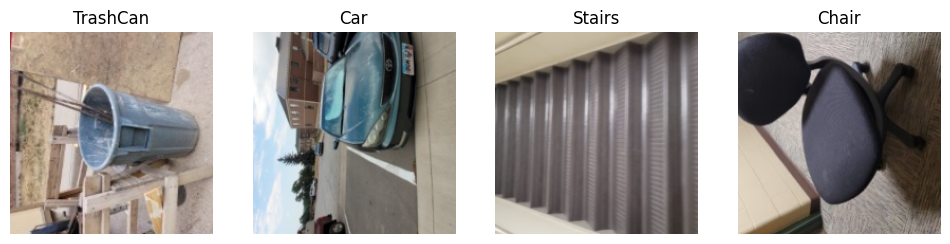

In [17]:
TrainingData = TrainingData.new(item_tfms=RandomResizedCrop(192, min_scale=0.3))
dls = TrainingData.dataloaders(path)
dls.show_batch(max_n=4, nrows=1)

### **What might the advantages, or disadvantages, be of using `RandomResizedCrop`?**

## We've seen what `item_tfms` does, what about `batch_tfms`?

The `batch_tfm` parameter in a `DataBlock` is used to specify transformations that should be applied to batches of data after they have been assembled but before they are passed to the model. In our earlier code, for the `pets` `DataBlock` we did not specify a batch size (`bs=`), but we will do that in the code below, setting it to `30`.

To focus on just the `batch_tfms` parameter, we'll leave `item_tfms` alone, besides resizing, for the example below. What's important to note is that augmenting the data on entire batches is possible once we've resized the data to all be the same size.

Run the code cell below a few times and take note of what you think is going on?

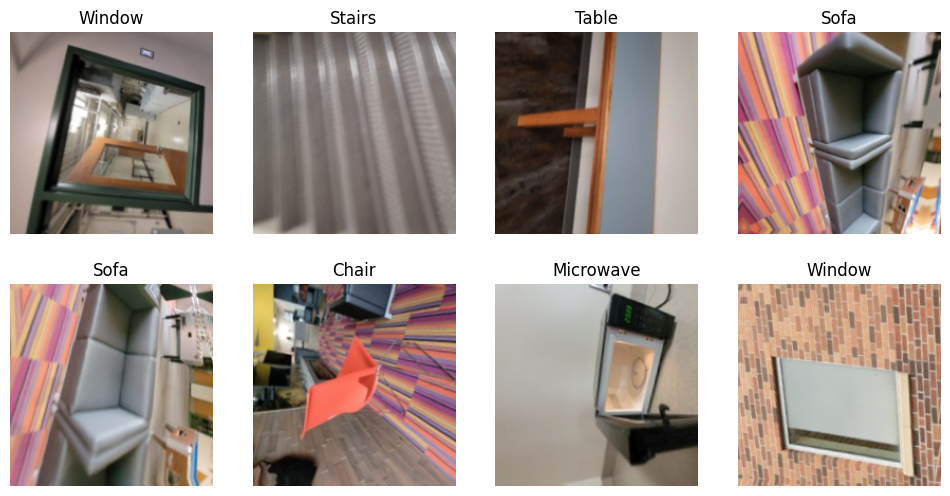

In [18]:
TrainingData = TrainingData.new(item_tfms=Resize(192), batch_tfms=aug_transforms())
dls = TrainingData.dataloaders(path, bs=30)
dls.show_batch(max_n=8, nrows=2, ncols=4)

### **What do you notice about the difference between the item transforms we used earlier, and what is occuring when we apply data augmentation to batches of data?**

To read more about what is possible with data augmentation, check out the documentation at [https://docs.fast.ai/vision.augment.html](https://docs.fast.ai/vision.augment.html).

I encourage you to try out different for augmenting the data.

When we discussed collecting data, we wanted to ensure that we had variety in the images that we collected. Data augmentation is another way to introduce variety into the training process, without actually having to modify our original images.

**NOTE: ChatGPT can be a great helper if you're not sure how to write the code for augmenting data in the way that you want. Ask it you help you write that code if you're feeling stuck.**

## Putting It All Together

In the code cell below, write create a block of code that will create a `DataLoader` that you may want to use for training your dataset.

The code below will still use the pets data, because the `path` variable points to that data. If your data is in the `/workspace/data/` folder, you can reassign that `path` variable to your data and see what it comes up with.

In [19]:
import numpy as np
from PIL import Image
import torch
from fastai.vision.all import *

def keep_pink(img: TensorImage):
    # Check if the input has a batch dimension
    if len(img.shape) == 4:
        # Apply the function to each image in the batch
        return torch.stack([keep_pink(single_img) for single_img in img])
    
    # Move the tensor to CPU if it's on GPU
    img = img.cpu()
    
    # Convert tensor to numpy array
    img_array = img.permute(1, 2, 0).numpy().astype(np.uint8)
    
    # Define pink color range
    lower_pink = np.array([140, 0, 100])
    upper_pink = np.array([255, 105, 180])
    
    # Create a mask to keep only pink colors
    mask = ((img_array >= lower_pink) & (img_array <= upper_pink)).all(axis=-1)
    
    # Create an output image and apply the mask
    output_img = np.zeros_like(img_array)
    output_img[mask] = img_array[mask]
    
    # Convert numpy array back to tensor and permute dimensions back to original format
    output_img = torch.tensor(output_img).permute(2, 0, 1)
    
    return TensorImage(output_img)

path = '/workspace/data/TrainingData'

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(192), 
    batch_tfms=[*aug_transforms(), keep_pink]
).dataloaders(path, bs=30)


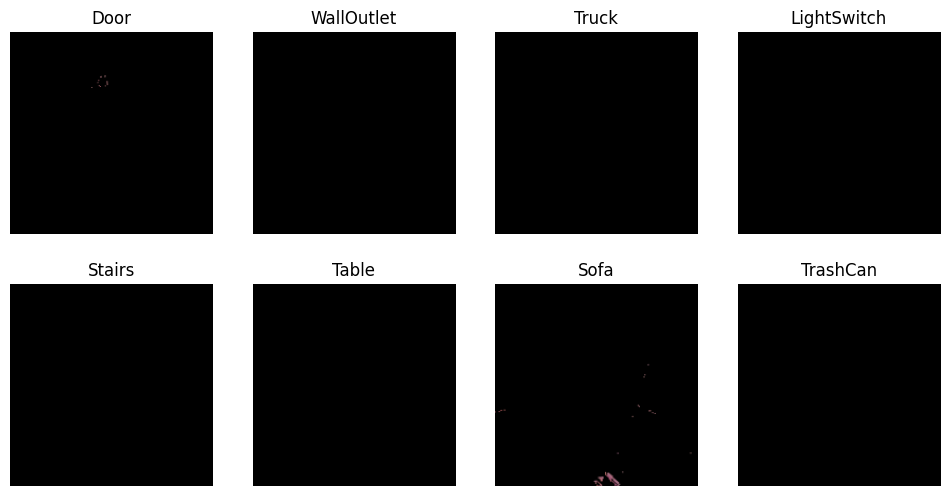

In [20]:
dls.show_batch(max_n=8, nrows=2, ncols=4)